#### Import Libraries

In [1]:
import pandas as pd # data wrangling
import tensorflow as tf # deep learning
import numpy as np # math
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # data viz 1
import seaborn as sns # data viz 2
import statistics

#### Import data

In [2]:
complaints_df = pd.read_csv('complaints-2019-06-29_08_09.csv', usecols = ['Product', 'Complaint ID', 'Consumer complaint narrative'])
complaints_df.drop_duplicates(inplace=True)
print("Dataframe's shape", complaints_df.shape)
print("Unique # of Complaints", len(complaints_df['Complaint ID'].unique()))

Dataframe's shape (144319, 3)
Unique # of Complaints 144319


In [3]:
complaints_df.Product.value_counts().head()

Credit reporting, credit repair services, or other personal consumer reports    59944
Debt collection                                                                 31538
Credit card or prepaid card                                                     14483
Mortgage                                                                        12475
Checking or savings account                                                      8676
Name: Product, dtype: int64

In [4]:
complaints_df['is_debt_collection'] = np.where(complaints_df['Product']=='Debt collection', 1, 0)

In [5]:
complaints_df.is_debt_collection.value_counts()

0    112781
1     31538
Name: is_debt_collection, dtype: int64

In [6]:
train_df, test_df = train_test_split(complaints_df, test_size = 0.3)

In [7]:
tokenizer_ks = keras.preprocessing.text.Tokenizer(num_words=6000, filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

In [8]:
tokenizer_ks.fit_on_texts(train_df['Consumer complaint narrative'])

In [9]:
print(tokenizer_ks.texts_to_sequences(["i was charged extra $"])) 

[[3, 11, 250, 935, 505]]


In [10]:
train_vec = tokenizer_ks.texts_to_sequences(train_df['Consumer complaint narrative'])
test_vec  = tokenizer_ks.texts_to_sequences(test_df['Consumer complaint narrative'])

In [11]:
lengths = [len(i) for i in train_vec]

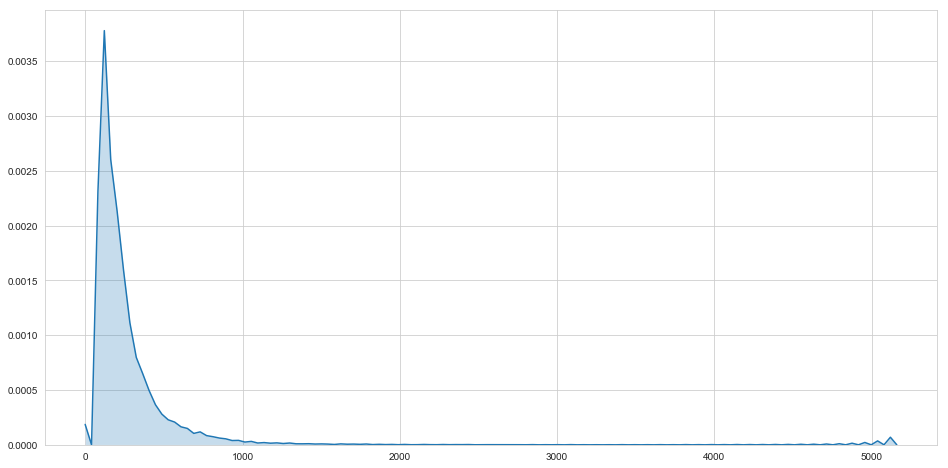

In [12]:
plt.figure(figsize=(16, 8))
sns.set_style('whitegrid')
sns.kdeplot(np.array(lengths), bw=0.5, shade=True)

In [13]:
train_data = keras.preprocessing.sequence.pad_sequences(train_vec,
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_vec,
                                                       padding='post',
                                                       maxlen=256)

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer_ks.word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [15]:
decode_review(train_data[0])

"house on the market and i asked for a pay off statement and they included late fees i called them several times sent many emails but they are being unreasonable it has been very stressful to deal with them recently i was able to make a payment on line but they have included late fees and i can't make the payment online unless i pay the amount they specify there which includes a late fee i have asked them to remove the late fee so i can pay online but they have not done it this month i paid over the phone because of the issues i'm having with them i didn't want my check to get there after the xxxx they charged me a convenience fee $12 00 i really need this issue to be solved because once i sell my house i don't want to see late fees included in my pay off amount it is not right i have a question my mortgage is variable but since my bankruptcy from xxxx to xxxx xxxx made very little changes in my monthly payment after it changed to sls they have increased my payment by around $20 00 eve

In [16]:
decode_review(train_vec[0])

"my mortgage debt was discharged in xxxx since then i'm voluntarily paying the mortgage i do want to keep my home since xxxx have not missed a single payment sometimes i send i paid after the xxxx of the month but always before the xxxx xxxx was servicing my mortgage since xxxx and i never had any issues with them last year the servicing of my mortgage was transferred to sls and my problems started first i wasn't able to pay online like i did before they told me i wasn't allowed because i had filed for bankruptcy i never missed a payment since xxxx but sometimes my check at their office a few days after the xxxx of the month and they started to charge me late fees i retired this year and i receive my pension every xxxx wednesday of the month i called to remind them my debt was discharged and that i was voluntarily paying my mortgage and they couldn't charge me late fees for a debt i legally don't own they were rude to me asked to speak to the manager but he didn't want to speak with me

In [17]:
# input shape is the vocabulary count used for the complaint data (6000 words)
vocab_size = 6000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          96000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 96,289
Trainable params: 96,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [19]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_df.is_debt_collection[:10000]
partial_y_train = train_df.is_debt_collection[10000:]

In [20]:
x_val.shape

(10000, 256)

In [21]:
partial_x_train.shape

(91023, 256)

In [22]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 91023 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
91023/91023 [==============================] - 9s 97us/sample - loss: 0.5553 - acc: 0.7803 - val_loss: 0.4957 - val_acc: 0.7806
Epoch 2/40
91023/91023 [==============================] - 7s 78us/sample - loss: 0.4488 - acc: 0.7867 - val_loss: 0.3755 - val_acc: 0.8217
Epoch 3/40
91023/91023 [==============================] - 7s 78us/sample - loss: 0.3168 - acc: 0.8656 - val_loss: 0.2799 - val_acc: 0.8843
Epoch 4/40
91023/91023 [==============================] - 7s 81us/sample - loss: 0.2688 - acc: 0.8938 - val_loss: 0.2595 - val_acc: 0.8954
Epoch 5/40
91023/91023 [==============================] - 7s 76us/sample - loss: 0.2539 - acc: 0.9008 - val_loss: 0.2503 - val_acc: 0.9030
Epoch 6/40
91023/91023 [==============================] - 8s 85us/sample - loss: 0.2452 - acc: 0.9043 - val_loss: 0.2455 - val_acc: 0.9018
Epoch 7/40
91023/91023 [==============================] - 7s 75us/sa

In [23]:
results = model.evaluate(test_data, test_df.is_debt_collection)

print(results)

43296/43296 [==============================] - 1s 26us/sample - loss: 0.2389 - acc: 0.9107
[0.23892742525221725, 0.9106846]


In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

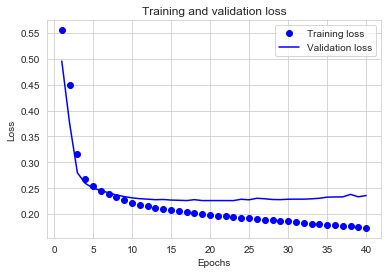

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

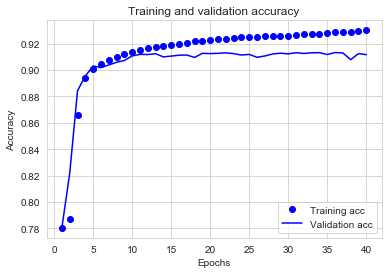

In [26]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Traditional Machine Learning

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import accuracy_score

In [29]:
train_df.columns

Index(['Product', 'Consumer complaint narrative', 'Complaint ID',
       'is_debt_collection'],
      dtype='object')

In [48]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             max_df=0.9,
                             min_df=10,
                             token_pattern=r'\b[^\d\W]+\b',
                             stop_words='english')

X_train = vectorizer.fit_transform(train_df['Consumer complaint narrative'])

In [49]:
X_train.shape

(101023, 11520)

In [50]:
X_test = vectorizer.transform(test_df['Consumer complaint narrative'])

In [51]:
clf = MultinomialNB(alpha=0.01)
clf.fit(X_train, train_df.is_debt_collection)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [52]:
y_predict = clf.predict(X_test)

In [53]:
accuracy_score(y_pred=y_predict, y_true=test_df.is_debt_collection)

0.8900129342202513